In [58]:
import json
import numpy as np
import pandas as pd
import scipy.stats as stats
from os import listdir
from os.path import isfile, join
import math
import random
from multiprocessing import Pool
import re
import matplotlib.pyplot as plt


In [2]:
f = open('anonymized_QAs.json')
qaDict = json.load(f)

llmList = ['ChatGPT',
           'Gemini']

dirList = ['reVLAT_Viz+Choices',
           'reVLAT_NoViz+Choices']

In [3]:
def resultsFunc(fileLoc,qaDict):
    resultFiles = [f for f in listdir(fileLoc) if isfile(join(fileLoc, f))]

    row = 0
    resultsDF = pd.DataFrame()
    for resultFile in resultFiles:
        nameList = resultFile.split('_')
        if (nameList[0] == '.DS'): continue
        chartType = nameList[1]
        qNum = nameList[2].split('.')[0]
        
        inputDict = qaDict[chartType]['QAs'][qNum]
        
        resultsDF.at[row,'index'] = int(nameList[0])
        resultsDF.at[row,'chartType'] = chartType
        resultsDF.at[row,'qNum'] = qNum
        resultsDF.at[row,'question'] = inputDict['Q']
        resultsDF.at[row,'answer'] = inputDict['A']
        resultsDF.at[row,'qType'] = inputDict['Type']
        
        f = open(fileLoc+'/'+resultFile)
        dataDict = json.load(f)
        
        resultsDF.at[row,'qaInput'] = dataDict['qaInput']
        resultsDF.at[row,'response'] = dataDict['response']
        resultsDF.at[row,'time'] = dataDict['time']
        
        qaInputList = dataDict['qaInput'].split('\n')
        answerList = [x for i, x in enumerate(qaInputList) if (inputDict['A'] in x)&(i > 1)]
        
        if len(answerList) == 1:
            respList = answerList[0].split(' ')
            respLetter = respList[0]

            if len(dataDict['letterResp']) == 1:
                resultsDF.at[row,'correct'] = respLetter==dataDict['letterResp'][0]
            else:
                resultsDF.at[row,'correct'] = False
        else:
            print('STAHHHHHP',answerList,dataDict)
        
        row += 1
    
    return resultsDF

In [4]:
dfList = []
for llm in llmList:
    for condition in dirList:
        filePath = llm+'/'+condition
        resultsDF = resultsFunc('Results/'+filePath, qaDict)
        resultsDF['qType_simple'] = resultsDF['qType'].apply(lambda x:x.split(' (')[0].lower())
        resultsDF['expType'] = condition
        resultsDF['LLM'] = llm
        dfList.append(resultsDF)

fullDF = pd.concat(dfList)
fullDF = fullDF.reset_index(drop=True)


/var/folders/q2/n2982g891rl639fmblv6mkzw0000gq/T/ipykernel_77632/2875153677.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  resultsDF.at[row,'correct'] = respLetter==dataDict['letterResp'][0]
/var/folders/q2/n2982g891rl639fmblv6mkzw0000gq/T/ipykernel_77632/2875153677.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  resultsDF.at[row,'correct'] = respLetter==dataDict['letterResp'][0]
/var/folders/q2/n2982g891rl639fmblv6mkzw0000gq/T/ipykernel_77632/2875153677.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cas

In [5]:

def numCorrCalc(resultDF,
                filDict,
                qaDict):
    llmFil = resultDF['LLM']==filDict['LLM']
    expTypeFil = resultDF['expType']==filDict['expType']
    filResultDF = resultDF.loc[llmFil&expTypeFil,:]
    
    row = 0
    outputDF = pd.DataFrame()
    for chartType in qaDict.keys():
        tempDict = qaDict[chartType]['QAs']
        
        for qNumStr in tempDict.keys():
            chartTypeFil = filResultDF['chartType']==chartType
            qNumFil = filResultDF['qNum']==qNumStr
            filFilResultDF = filResultDF.loc[chartTypeFil&qNumFil,:]
            filFilResultDF.reset_index(drop=True,
                                       inplace=True)
            
            outputDF.at[row,'chartType'] = chartType
            outputDF.at[row,'qNum'] = qNumStr
            outputDF.at[row,'qType'] = filFilResultDF.at[0,'qType']
            outputDF.at[row,'qType_simple'] = filFilResultDF.at[0,'qType_simple']
            outputDF.at[row,'numCorr'] = sum(filFilResultDF['correct'])
            outputDF.at[row,'totalNum'] = len(filFilResultDF['correct'])
            outputDF.at[row,'percentCorr'] = sum(filFilResultDF['correct'])/len(filFilResultDF['correct'])
            
            row += 1
    
    return outputDF

In [6]:
numCorrDF_list = []
for llm in llmList:
    for dirLoc in dirList:
        resultsDF = numCorrCalc(fullDF,
                                {'LLM':llm,
                                 'expType':dirLoc},
                                qaDict)
        resultsDF['expType'] = dirLoc
        resultsDF['LLM'] = llm
        numCorrDF_list.append(resultsDF)

numCorrAnonDF = pd.concat(numCorrDF_list)
numCorrAnonDF = numCorrAnonDF.reset_index(drop=True)

# numCorrAnonDF.head(1000)

# numCorrDF.to_csv('Results/allAnonResults.csv',index=False)

In [5]:
# corrDF = fullDF
# corrDF['corrInt'] = corrDF['correct'].apply(lambda x: int(x))

In [70]:
def questionAccuracyRate(df, property, model, interestedValue):
    df = df[df["LLM"] == model]
    stats = df.groupby([property,'expOrder'])[interestedValue].agg(['mean', 'count', 'std'])
    
    ci95_hi = []
    ci95_lo = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        # print(i, m, c, s)
        ci95_hi.append(m + 1.96*s/math.sqrt(c))
        ci95_lo.append(m - 1.96*s/math.sqrt(c))
    
    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo
    
    return stats

In [66]:
# Creating Confidence Interval
def createCIFigure(stats, model, property, expType):
    xerr = [[mean - low for mean, low in zip(stats['mean'], stats['ci95_lo'])], [hi - mean for mean, hi in zip(stats['mean'], stats['ci95_hi'])]]

    font = {'fontname':'Arial'}

    labels = [] 
    for a, b in stats.index.tolist():
        labels.append(a+' in '+ b)
    # stats.index.get_level_values(0).tolist()
    print(stats.index)

    y = np.arange(len(labels))
    width = 0.2

    plt.figure(figsize=(100, 50))
    fig, ax = plt.subplots()

    ax.barh(y, stats['mean'], width, label='Mean', xerr=xerr, color="#5f89c2", capsize = 3, ecolor="#001D4A")

    # Add labels, title, and legend
    ax.set_ylabel("Accuracy Rate", **font, fontsize=12)
    ax.set_title(model+" Accuracy Rate in Experiment 1 and Follow up study", **font, fontsize=12)
    ax.set_yticks(y)
    ax.set_yticklabels(labels, **font, fontsize=12)
    ax.legend()

    # plt.xlim(0, 2.5)
    plt.grid(axis='x', color='gray', linestyle='-', linewidth=0.5)
    plt.savefig("Results/"+model+"_CI_"+property+expType+".pdf")
    # Show plot
    plt.show()

In [4]:
resultsE1DF = pd.read_csv('../Analysis/choiceResults.csv')
resultsE1DF = resultsE1DF.loc[(resultsE1DF['chartType'] != 'Histogram') &
                            (resultsE1DF['chartType'] != 'Scatterplot') &
                            (resultsE1DF['chartType'] != 'Choropleth Map')]

resultsE1DF['expOrder'] = 'E1'

In [5]:
resultsFollowDF = pd.read_csv('Results/allAnonResults.csv')
resultsFollowDF['expOrder'] = 'followup'

MultiIndex([('100% Stacked Bar Chart',       'E1'),
            ('100% Stacked Bar Chart', 'followup'),
            (            'Area Chart',       'E1'),
            (            'Area Chart', 'followup'),
            (             'Bar Chart',       'E1'),
            (             'Bar Chart', 'followup'),
            (          'Bubble Chart',       'E1'),
            (          'Bubble Chart', 'followup'),
            (            'Line Chart',       'E1'),
            (            'Line Chart', 'followup'),
            (             'Pie Chart',       'E1'),
            (             'Pie Chart', 'followup'),
            (    'Stacked Area Chart',       'E1'),
            (    'Stacked Area Chart', 'followup'),
            (     'Stacked Bar Chart',       'E1'),
            (     'Stacked Bar Chart', 'followup'),
            (               'Treemap',       'E1'),
            (               'Treemap', 'followup')],
           names=['chartType', 'expOrder'])


<Figure size 10000x5000 with 0 Axes>

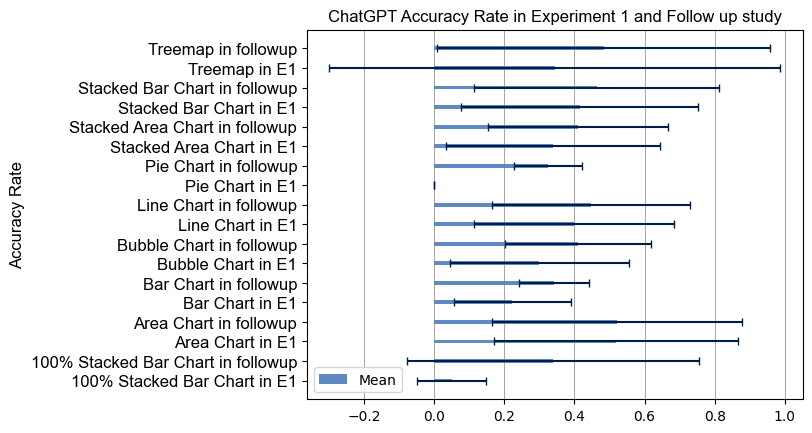

In [64]:
allResults = pd.concat([resultsE1DF, resultsFollowDF])

model = 'ChatGPT'
property = 'chartType'
expType = 'reVLAT_Viz+Choices'

withVisResults = allResults[allResults['expType'] == expType]

stats = questionAccuracyRate(withVisResults, property, model, 'percentCorr')
createCIFigure(stats, model, property, expType)

In [51]:
randomChoices = {
    "Line Chart": {
        1: 0.25,
        2: 0.25,
        3: 0.25,
        4: 0.33,
        5: 0.25
    },
    "Bar Chart": {
        1: 0.25,
        2: 0.25,
        3: 0.25,
        4: 0.33
    },
    "Stacked Bar Chart": {
        1: 0.25,
        2: 0.25,
        3: 0.25,
        4: 0.50,
        5: 0.50
    },
    "100% Stacked Bar Chart": {
        1: 0.25,
        2: 0.25,
        3: 0.50
    },
    "Pie Chart": {
        1: 0.25,
        2: 0.25,
        3: 0.50
    },
    "Bubble Chart": {
        1: 0.25,
        2: 0.25,
        3: 0.25,
        4: 0.25,
        5: 0.50,
        6: 0.50,
        7: 0.50
    },
    "Area Chart": {
        1: 0.25,
        2: 0.25,
        3: 0.25,
        4: 0.33
    },
    "Stacked Area Chart": {
        1: 0.25,
        2: 0.25,
        3: 0.25,
        4: 0.33,
        5: 0.50,
        6: 0.50
    },
    "Treemap": {
        1: 0.25,
        2: 0.50,
        3: 0.50
    }
}

In [62]:
# Examine whether the followup novis results is closer to baseline random
noVisResults = allResults[allResults['expType'] == 'reVLAT_NoViz+Choices']
diffNoVisResults = pd.DataFrame(columns=['chartType', 'qNum', 'qType_simple', 'percentCorr', 'expType', 'LLM', 'expOrder', 'diff'])
i = 0
for index, row in noVisResults.iterrows():
    chartType = row['chartType']
    qNum = row['qNum']
    diffNoVisResults.loc[i] = [chartType, qNum, row['qType_simple'],
                                row['percentCorr'], row['expType'], row['LLM'], row['expOrder'],
                                abs(randomChoices[chartType][qNum] - row['percentCorr'])]
    i += 1


MultiIndex([(                    'determine range',       'E1'),
            (                    'determine range', 'followup'),
            (                     'find anomalies',       'E1'),
            (                     'find anomalies', 'followup'),
            (                      'find clusters',       'E1'),
            (                      'find clusters', 'followup'),
            (           'find correlations/trends',       'E1'),
            (           'find correlations/trends', 'followup'),
            (                      'find extremum',       'E1'),
            (                      'find extremum', 'followup'),
            ('identify the hierarchical structure',       'E1'),
            ('identify the hierarchical structure', 'followup'),
            (                   'make comparisons',       'E1'),
            (                   'make comparisons', 'followup'),
            (                     'retrieve value',       'E1'),
            (            

<Figure size 10000x5000 with 0 Axes>

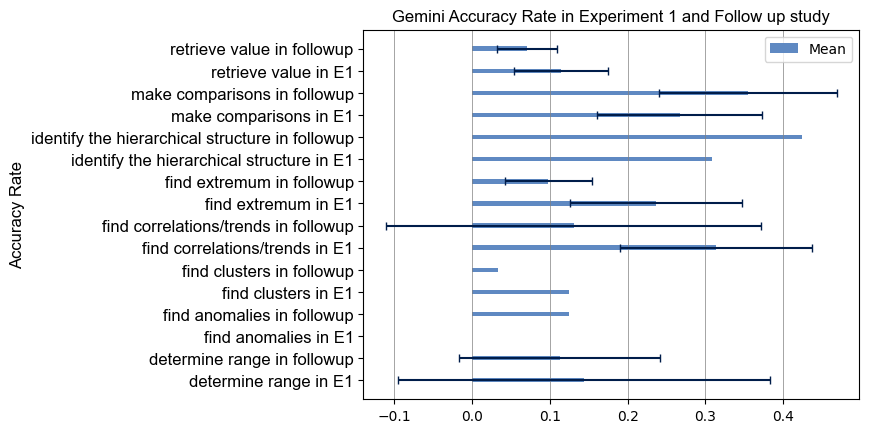

In [73]:
model = 'ChatGPT'
property = 'qType_simple'
expType = 'reVLAT_NoViz+Choices'

stats = questionAccuracyRate(diffNoVisResults, property, model, 'diff')
createCIFigure(stats, model, property, expType)